This a 3D modification, of a 2D method, described in GPU Gems - http://developer.download.nvidia.com/books/HTML/gpugems/gpugems_ch38.html
<br><br>
Steps are:
1. Generate base terrain mesh and assign biomes to it
1. Simulate biosphere in this environment
1. ..Try some stone mesh generation stuff

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['image.cmap'] = 'gray'
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, to_rgb
import os
import time
import seaborn
import numpy as np
import scipy as sc
# from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, delaunay_plot_2d
# from shapely.ops import polygonize
# from shapely.geometry import LineString, Polygon, MultiPolygon, MultiPoint, Point
# from descartes.patch import PolygonPatch
# from noise import snoise2

import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

import ipyvolume.pylab as p3

# from plotly import graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(True)

from world_gen_pb2 import *

Routines for visualizing simulation data

In [2]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    Ref: http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
    """
    # Get rid of the margins
    fig.gca().set_axis_off()
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    #fig.margins(0,0)
    from matplotlib.ticker import NullLocator
    fig.gca().xaxis.set_major_locator(NullLocator())
    fig.gca().yaxis.set_major_locator(NullLocator())
    
    # draw the renderer
    fig.canvas.draw ( )

    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape((h, w, 3))
    #buf = buf.transpose((1, 0, 2))
    #buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    #buf.shape = ( w, h,4 )
    
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    #buf = np.roll ( buf, 3, axis = 2 )
    return buf

def frames2web(frames, fps=60):
    """Converts NxHxWxC NumPu array into Base64-encode video, wrapped in HTML (for Visdom visualization)"""
    import skvideo.io
    import tempfile
    import mimetypes
    import base64
    videofile = '/tmp/%s.mp4' % next(tempfile._get_candidate_names())
    skvideo.io.vwrite(videofile, frames,
                      inputdict={
                        "-r": "%d" % fps
                      },
                      outputdict={
                        "-b": "4000000"
                      })

    extension = videofile[-3:].lower()
    mimetypes = dict(mp4='mp4', ogv='ogg', avi='avi', webm='webm')
    mimetype = mimetypes.get(extension)

    with open(videofile, 'rb') as f:
        bytestr = f.read()
    videodata = """
        <video width="%d" controls>
            <source type="video/%s" src="data:video/%s;base64,%s">
            Your browser does not support the video tag.
        </video>
    """ % (frames.shape[2]*1.5, mimetype, mimetype, base64.b64encode(bytestr).decode('utf-8'))
    return videodata

from IPython.display import HTML


from visdom import Visdom
viz = Visdom()
viz_opts = {
    'sim_slice': dict()
}
viz_windows = { k: None for k in viz_opts.keys() }
# vizdom .video() modified to use scikit-video instead of OpenCV
def viz_video(frames, win=None, env=None, opts=None, fps=60):
    return viz.text(text=frames2web(frames, fps), win=win, env=env, opts=opts)

Generate a terrain mesh and assign biomes

In [3]:
rnd = np.random.RandomState(1)

# Setup some terrain parmeters
map_scale=0.4
nblocks = (2,2)
map_size=(1024 * nblocks[0], 1024 * nblocks[1])
real_size=(500.0 * nblocks[0], 170.0, 500.0 * nblocks[1])
block_size = 32

biome_colors = np.array([
    to_rgb('#002244'), # Deep Water
    to_rgb('#2288aa'), # Water
    to_rgb('#228844'), # Forest
    to_rgb('#6c6964'), # Rocks
    to_rgb('#ffffff'), # Mountains
    to_rgb('#4c4944') # Dirt
])
nbiomes = biome_colors.shape[0]
# Load CUDA-based generation functions
with open('cuda/terrain_base.cu', 'r') as f:
    mod = SourceModule(f.read() % {
            'map_w': map_size[0],
            'map_h': map_size[1],
            'map_scale': map_scale * 4000.0,
            'slope_scale': real_size[1] / (real_size[0] / map_size[0]),
            'nbiomes': nbiomes
        },
        include_dirs=[ os.getcwd() ],
        no_extern_c=True,
        options=[ '-Xcudafe', '"--diag_suppress=code_is_unreachable,branch_past_initialization"' ]
    )
# warning suppression codes: http://www.ssl.berkeley.edu/~jimm/grizzly_docs/SSL/opt/intel/cc/9.0/lib/locale/en_US/mcpcom.msg
make_noise = mod.get_function("make_noise")
assign_biome = mod.get_function("assign_biome")

# Generate terrain mesh
heightmap = np.zeros(map_size).astype(np.float32)
make_noise(
        drv.Out(heightmap),
        block=(block_size, block_size, 1), grid=(map_size[0] // block_size, map_size[1] // block_size)
)
heightmap -= np.min(heightmap)
heightmap /= np.max(heightmap)
sea_level = np.median(heightmap)

# Assign biomes to the mesh
biome_map = np.zeros((heightmap.shape[0], heightmap.shape[1], nbiomes)).astype(np.float32)
assign_biome(
    drv.Out(biome_map), drv.In(heightmap), sea_level,
    block=(block_size, block_size, 1), grid=(map_size[0] // block_size, map_size[1] // block_size)
)
biome_map = np.maximum(biome_map, 0.0)
biome_map /= np.sum(biome_map, axis=2, keepdims=True)

# # Show flat biome map
# fig, ax = plt.subplots(2, 2, figsize=(20, 16))
# ax[0,0].grid(False)
# ax[0,0].imshow(np.dot(biome_map, biome_colors))
# ax[0,1].grid(False)
# ax[0,1].imshow(heightmap, cmap='gray', vmin=0, vmax=1)
# _ = ax[1,1].hist(np.ravel(heightmap), bins=100)

# Visualize sumbsampled terrain
plot_subsample = 8
map4plot = heightmap[::plot_subsample,::plot_subsample]
x4plot, y4plot = np.meshgrid(np.arange(map4plot.shape[0]), np.arange(map4plot.shape[1]))

fig = p3.figure(width=900, height=600, lighting=True)
mesh = p3.plot_mesh(
    x4plot, 
    y4plot,
    map4plot.ravel() * real_size[1] / real_size[0] + 0.5,
    wireframe=False,
    color=np.dot(biome_map, biome_colors)[::plot_subsample,::plot_subsample].ravel()
)
p3.show()

# # Show vegetation density
# vegetation_density = np.zeros_like(heightmap, dtype=np.float32)
# get_vegetation_density = mod.get_function("get_vegetation_density")
# get_vegetation_density(
#     drv.In(heightmap), sea_level, drv.In(biome_map), drv.Out(vegetation_density),
#     block=(block_size, block_size, 1), grid=(map_size[0] // block_size, map_size[1] // block_size)
# )

# fig, ax = plt.subplots(figsize=(12, 12))
# BIOME_GRASS = 2
# BIOME_ROCKS = 3
# BIOME_DIRT = 5
# #tmap = ax.imshow(biome_map[...,BIOME_ROCKS], cmap=plt.get_cmap('coolwarm'))
# tmap = ax.imshow(vegetation_density, cmap=plt.get_cmap('coolwarm'))
# fig.colorbar(tmap, ax=ax)

A Jupyter Widget

And now, time for the biosphere simulation!  

In [13]:
import pycuda.gpuarray as gpuarray

# Setup simulation parameters
cell_scale = np.float32(1.0)
viscosity = np.float32(10.0)
sim_timestep = 0.2
sim_time = 0.0
sim_subsample = 16
sim_depth = 32
sim_depth_sqrt = 8
height4sim = heightmap[::sim_subsample,::sim_subsample]
sim_shape = (height4sim.shape[0], height4sim.shape[1], sim_depth)

start_density = 1.0

# Initialize simulation buffers
surface_height_gpu = gpuarray.to_gpu(height4sim.astype(np.float32))
velocity_gpu = gpuarray.to_gpu(np.zeros((sim_shape[0], sim_shape[1], sim_shape[2], 3), dtype=np.float32))
pressure_gpu = gpuarray.to_gpu(np.zeros(sim_shape).astype(np.float32))
next_pressure_gpu = gpuarray.to_gpu(np.zeros(sim_shape).astype(np.float32))
divergence_gpu = gpuarray.to_gpu(np.zeros(sim_shape).astype(np.float32))
temperature_gpu = gpuarray.to_gpu(np.ones(sim_shape).astype(np.float32))
humidity_gpu = gpuarray.to_gpu(np.zeros(sim_shape).astype(np.float32))
next_velocity_gpu = gpuarray.to_gpu(np.zeros((sim_shape[0], sim_shape[1], sim_shape[2], 3), dtype=np.float32))
next_temperature_gpu = gpuarray.to_gpu(np.ones(sim_shape).astype(np.float32))
next_humidity_gpu = gpuarray.to_gpu(np.zeros(sim_shape).astype(np.float32))
precipitation_gpu = gpuarray.to_gpu(np.zeros(sim_shape).astype(np.float32))
last_precipitation_gpu = gpuarray.to_gpu(np.zeros(sim_shape).astype(np.float32))

# Load CUDA-base simulation functions
with open('cuda/sim.cu', 'r') as f:
    mod = SourceModule(f.read() % {
        'sim_w': sim_shape[0],
        'sim_h': sim_shape[1],
        'sim_d': sim_shape[2],
        'sea_level': sea_level,
        'sim_d_scale': float(sim_shape[0]) / float(sim_depth) * (float(real_size[1]) / real_size[0]),
        'cell_scale': cell_scale,
        'sim_timestep': sim_timestep,
    },
    include_dirs=[ os.getcwd() ],
    no_extern_c=True,
    options=[ '-Xcudafe', '"--diag_suppress=code_is_unreachable,branch_past_initialization"' ]
)

# Get function handles
zero3d = mod.get_function("zero3d")
copy3d = mod.get_function("copy3d")

advect = mod.get_function("advect")
advect_self = mod.get_function("advect_self")
jacobi_f = mod.get_function("jacobi_f")
jacobi_f3 = mod.get_function("jacobi_f3")
temperature_flux = mod.get_function("temperature_flux")
convection = mod.get_function("convection")
water_cycle = mod.get_function("water_cycle")
divergence = mod.get_function("divergence")
gradient = mod.get_function("gradient")
boundary_f = mod.get_function("boundary_f")
boundary_f3 = mod.get_function("boundary_f3")

block_size = 4
t = time.time()
# How many timesteps to simulate?
niter = 2000

last_precipitation = np.zeros_like(precipitation_gpu.get())

# Storage variables for simulation states
humidity_history_3d = []
precipitation_history_3d = []
temperature_history_3d = []

humidity_history = []
precipitation_history = []
divergence_history = []
pressure_history = []
temperature_history = []
velocity_history = []
humidity_history_xz = []
temperature_history_xz = []

# Slice index, to capture for 2d visualiation
J = 40
# CUDA cores configuration
block3d = (block_size, block_size, sim_depth)
grid = (sim_shape[0] // block_size, sim_shape[1] // block_size)
for i in np.arange(niter):
    # Move air masses with their temperature
    advect(cell_scale, velocity_gpu, temperature_gpu, next_temperature_gpu, surface_height_gpu,
          block=block3d, grid=grid)
    temperature_gpu, next_temperature_gpu = next_temperature_gpu, temperature_gpu
    
    # ..humidity
    advect(cell_scale, velocity_gpu, humidity_gpu, next_humidity_gpu, surface_height_gpu,
          block=block3d, grid=grid)
    humidity_gpu, next_humidity_gpu = next_humidity_gpu, humidity_gpu
    
    # ..and velocity
    advect_self(cell_scale, velocity_gpu, next_velocity_gpu, surface_height_gpu,
          block=block3d, grid=grid)
    velocity_gpu, next_velocity_gpu = next_velocity_gpu, velocity_gpu
    
    # Sun heating the ground, air cooling with ascent, heat outflux into the outer scape
    temperature_flux(temperature_gpu, next_temperature_gpu, velocity_gpu, surface_height_gpu, 
                        np.float32(sim_time),
                        humidity_gpu, precipitation_gpu, last_precipitation_gpu,
                        block=block3d, grid=grid)
    temperature_gpu, next_temperature_gpu = next_temperature_gpu, temperature_gpu
    
    copy3d(precipitation_gpu, last_precipitation_gpu,
                block=block3d, grid=grid)
    # Air absorbs surface water
    water_cycle(humidity_gpu, precipitation_gpu,
                surface_height_gpu, temperature_gpu,
                block=block3d, grid=grid)
    
    # Buoyancy and convection
    convection(velocity_gpu, next_velocity_gpu, surface_height_gpu, 
                temperature_gpu, np.median(temperature_gpu.get()), 
                humidity_gpu, np.median(humidity_gpu.get()), 
                np.float32(sim_time),
                block=block3d, grid=grid)
    velocity_gpu, next_velocity_gpu = next_velocity_gpu, velocity_gpu
    
    # Iteratively solve for velocity distribution
    for j in np.arange(20):
        alpha_param = np.float32(cell_scale**2 / (viscosity * sim_timestep))
        jacobi_f3(alpha_param, np.float32(1.0 / (6.0 + alpha_param)), velocity_gpu, next_velocity_gpu, 
                  surface_height_gpu,
                  block=block3d, grid=grid)
        velocity_gpu, next_velocity_gpu = next_velocity_gpu, velocity_gpu

    # How much non-uniformly pressure bacomes distributed
    divergence(np.float32(0.5 / cell_scale), velocity_gpu, divergence_gpu, surface_height_gpu,
              block=block3d, grid=grid)
    
    zero3d(pressure_gpu, block=block3d, grid=grid)
    zero3d(next_pressure_gpu, block=block3d, grid=grid)
    for j in np.arange(40):
        jacobi_f(np.float32(-(cell_scale**2)), np.float32(1.0 / 6.0), pressure_gpu, next_pressure_gpu, 
                    divergence_gpu, surface_height_gpu,
                    block=block3d, grid=grid)
        pressure_gpu, next_pressure_gpu = next_pressure_gpu, pressure_gpu
    
    # Fix velocities to normalize pressure distibution
    gradient(np.float32(0.5 / cell_scale), pressure_gpu, velocity_gpu, next_velocity_gpu, surface_height_gpu,
          block=block3d, grid=grid)
    velocity_gpu, next_velocity_gpu = next_velocity_gpu, velocity_gpu
    
    # Maintain boundary conditions of zero gradient
    boundary_f3(np.float32(-1), velocity_gpu, surface_height_gpu,
             block=block3d, grid=grid)
    boundary_f(np.float32(1), pressure_gpu, surface_height_gpu,
             block=block3d, grid=grid)
    
    sim_time += sim_timestep

    if i % 8 == 0:
        # Store simulation frames for visualization
        humidity_history_3d.append(humidity_gpu.get().copy())
        precipitation_history_3d.append((precipitation_gpu.get() - last_precipitation)[:,J,:])
        temperature_history_3d.append(temperature_gpu.get().copy())
        
        humidity_history.append(humidity_gpu.get()[:,J,:].copy())
        precipitation_history.append((precipitation_gpu.get() - last_precipitation)[:,J,:])
        last_precipitation = precipitation_gpu.get()
        divergence_history.append(divergence_gpu.get()[:,J,:].copy())
        pressure_history.append(pressure_gpu.get()[:,J,:].copy())
        temperature_history.append(temperature_gpu.get()[:,J,:].copy())
        velocity_history.append(velocity_gpu.get()[:,J,:].copy())
        humidity_history_xz.append(np.sum(humidity_gpu.get()[:,:,:], axis=2))
        temperature_history_xz.append(np.sum(temperature_gpu.get()[:,:,:], axis=2))
        
    if i % 100 == 0:
        # Long simulations require garbage colleciton
        import gc
        gc.collect()
    
print('sim time: %f' % (time.time()-t))

humidity_history_3d = np.array(humidity_history_3d)
precipitation_history_3d = np.array(precipitation_history_3d)
temperature_history_3d = np.array(temperature_history_3d)
# Normalize simulation values
humidity_history_3d = humidity_history_3d - np.min(humidity_history_3d)
humidity_history_3d = humidity_history_3d / np.max(humidity_history_3d)
precipitation_history_3d = precipitation_history_3d - np.min(precipitation_history_3d)
precipitation_history_3d = precipitation_history_3d / np.max(precipitation_history_3d)
temperature_history_3d = temperature_history_3d - np.min(temperature_history_3d)
temperature_history_3d = temperature_history_3d / np.max(temperature_history_3d)

# Save simulation frames
sim_data_proto = SimulationData()
sim_data_proto.sim_shape.extend(sim_shape)
for i in np.arange(len(humidity_history_3d)):
    sim_frame_proto = sim_data_proto.frames.add()
    sim_frame_proto.humidity.extend(humidity_history_3d[i].ravel())
    sim_frame_proto.precipitation.extend(precipitation_history_3d[i].ravel())
    sim_frame_proto.temperature.extend(temperature_history_3d[i].ravel())
with open('sim_data.dat', 'wb') as f:
    f.write(sim_data_proto.SerializeToString())

humidity_history = np.array(humidity_history)[:,:,::-1].transpose((0,2,1))
precipitation_history = np.array(precipitation_history)[:,:,::-1].transpose((0,2,1))
divergence_history = np.array(divergence_history)[:,:,::-1].transpose((0,2,1))
pressure_history = np.array(pressure_history)[:,:,::-1].transpose((0,2,1))
temperature_history = np.array(temperature_history)[:,:,::-1].transpose((0,2,1))
velocity_history = np.array(velocity_history)[:,:,::-1].transpose((0,2,1,3))

#print(temperature_gpu.get()[np.where(humidity_gpu.get() >= high_flux)])
#_ = plt.hist(temperature_history[0][np.where(temperature_history[0] >= 0.0)].ravel(), bins=100)
# map4plot = heightmap[::plot_subsample,::plot_subsample]
# x4plot, y4plot = np.meshgrid(np.arange(map4plot.shape[0]), np.arange(map4plot.shape[1]))
# fig = p3.figure(width=900, height=500, lighting=True)
# mesh = p3.plot_mesh(
#     x4plot, 
#     y4plot,
#     (map4plot.ravel() + 0.1) / 1.2, #  * real_size[1] / real_size[0] + 0.5
#     wireframe=False,
#     #color=np.dot(biome_map, biome_colors)[::plot_subsample,::plot_subsample].ravel()
#     color=np.dot((precipitation_gpu.get() / np.max(precipitation_gpu.get()) * 2.0)[...,np.newaxis], biome_colors[:1]).ravel()
# )
# #p3.volshow(humidity_gpu.get().transpose((2,0,1)), level=[0.15, 0.43], opacity=[0.01, 0.03], level_width=0.1, data_min=0, data_max=4)
# #p3.volshow(temperature_gpu.get().transpose((2,0,1)), level=[0.15, 0.43], opacity=[0.01, 0.03], level_width=0.1, data_min=0, data_max=np.max(temperature_gpu.get()))
# p3.volshow(density_gpu.get().transpose((2,0,1)), level=[0.15, 0.43], opacity=[0.01, 0.03], level_width=0.1, data_min=0, data_max=np.median(density_gpu.get()) * 2)
# p3.show()

def show_frame(frame_num):
    """Visualizes humidity, precipitation and temperature slices"""
    fig, ax = plt.subplots(3, figsize=(6,5))
    
    tmap0 = ax[0].imshow(np.abs(humidity_history[frame_num]), cmap=plt.get_cmap('coolwarm'), vmin=0, vmax=np.max(np.abs(humidity_history)))
    ax[0].set_title('Humidity')
    tmap1 = ax[1].imshow(np.abs(precipitation_history[frame_num]), cmap=plt.get_cmap('coolwarm'), vmin=0, vmax=np.max(np.abs(precipitation_history)))
    ax[1].set_title('Precipitation')
    tmap2 = ax[2].imshow(np.abs(temperature_history[frame_num]), cmap=plt.get_cmap('coolwarm'), vmin=0, vmax=np.max(np.abs(temperature_history)))
    ax[2].set_title('Temperature')
    
#     line_scale = -0.5
#     lines = []
#     for i in np.arange(0, velocity_history[frame_num].shape[0], 3):
#         for j in np.arange(0, velocity_history[frame_num].shape[1], 3):
#             lines.append([(j, i), (j+velocity_history[frame_num][i,j,0] * line_scale, i+velocity_history[frame_num][i,j,2] * line_scale)])
#     from matplotlib import collections  as mc
#     lc = mc.LineCollection(lines, linewidths=1) # , colors=c
#     ax[2].add_collection(lc)
    
    ax[0].grid(False)
    fig.colorbar(tmap0, ax=ax[0])
    ax[1].grid(False)
    fig.colorbar(tmap1, ax=ax[1])
    ax[2].grid(False)
    fig.colorbar(tmap2, ax=ax[2])
    
    return fig2data(fig)

def show_frame_xz(frame_num):
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    tmap = ax[0].imshow(humidity_history_xz[frame_num], cmap=plt.get_cmap('coolwarm'), vmin=0, vmax=np.max(humidity_history_xz))
    #tmap = ax[0].imshow(np.abs(divergence_history[frame_num]), cmap=plt.get_cmap('coolwarm'), vmin=0, vmax=np.max(np.abs(divergence_history)))
    ax[0].grid(False)
    #fig.colorbar(tmap, ax=ax[0])
    tmap = ax[1].imshow(temperature_history_xz[frame_num], cmap=plt.get_cmap('coolwarm'), vmin=0, vmax=np.max(temperature_history_xz))
    #tmap = ax[1].imshow(np.abs(pressure_history[frame_num]), cmap=plt.get_cmap('coolwarm'), vmin=0, vmax=np.max(np.abs(pressure_history)))
    ax[1].grid(False)
    #fig.colorbar(tmap, ax=ax[1])
    
    return fig2data(fig)

frames = []
for frame_num in np.arange(temperature_history.shape[0]):
    frames.append(show_frame(frame_num))
    plt.close()

frames = np.array(frames)

# Convert frames to video and send to Visdom
viz_opts = {
    'sim_slice': dict(
        title='Sim slice',
        width=frames.shape[2]*1.5+40,
        height=frames.shape[1]*1.5+25
    )
}
viz_video(frames, opts=viz_opts['sim_slice'], fps=24)

sim time: 41.688567


'window_365e7a981c2bfc'

Show the resulting precipitation density

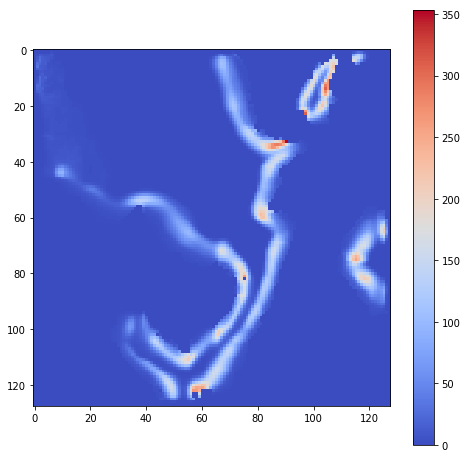

In [36]:
precipitation = np.sum(precipitation_gpu.get(), axis=2)
fig, ax = plt.subplots(figsize=(8,8))
tmap = ax.imshow(precipitation, cmap=plt.get_cmap('coolwarm'), vmin=0, vmax=np.max(precipitation))
ax.grid(False)
fig.colorbar(tmap, ax=ax)

In [14]:
# # Export for ParaView
# from pyevtk.hl import pointsToVTK
# map_c = np.dot(biome_map, biome_colors)[::plot_subsample,::plot_subsample].reshape((-1, 3))
# pointsToVTK("./terrain", x4plot.ravel().astype(np.float32), y4plot.ravel().astype(np.float32), map4plot.ravel() * real_size[1], data = {"color" : map_c})

### Here goes an experiment in generating stones (deformed geospheres)  
<br>
First, generate a base geosphere, from which all stone models will derive

In [4]:
# Generate a geosphere
# using pyDome: https://github.com/badassdatascience/pyDome
# further reading: http://richardssoftware.net/Home/Post/60

from pyDome.Polyhedral import *
from pyDome.SymmetryTriangle import *
from pyDome.GeodesicSphere import *

t = time.time()
radius = np.float64(1.)
frequency = 32
polyhedral = Icosahedron()
vertex_equal_threshold = 0.0000001
truncation_amount = 0.499999
symmetry_triangle = ClassOneMethodOneSymmetryTriangle(frequency, polyhedral)
sphere = GeodesicSphere(polyhedral, symmetry_triangle, vertex_equal_threshold, radius)
F_sphere = sphere.non_duplicate_face_nodes
V_sphere = sphere.sphere_vertices
orig_verts = np.array(V_sphere, dtype=np.float32)
faces = np.array(F_sphere, dtype=np.int32) - 1
nverts = orig_verts.shape[0]
print(time.time() - t)
print(nverts)

0.6100001335144043
10278


Generate a stone model

In [6]:
map_scale=0.4
nblocks = (2,2)
map_size=(1024 * nblocks[0], 1024 * nblocks[1])
real_size=(500.0 * nblocks[0], 170.0, 500.0 * nblocks[1])
block_size = 32
nbiomes = 6
with open('cuda/terrain_base.cu', 'r') as f:
    mod = SourceModule(f.read() % {
            'map_w': map_size[0],
            'map_h': map_size[1],
            'map_scale': map_scale * 4000.0,
            'slope_scale': 1.0 / (real_size[0] / map_size[0]) * real_size[1],
            'nbiomes': nbiomes
        },
        include_dirs=[ os.getcwd() ],
        no_extern_c=True,
        options=[ '-Xcudafe', '"--diag_suppress=code_is_unreachable,branch_past_initialization"' ]
    )
# warning suppression codes: http://www.ssl.berkeley.edu/~jimm/grizzly_docs/SSL/opt/intel/cc/9.0/lib/locale/en_US/mcpcom.msg
make_stone = mod.get_function("make_stone")

verts = np.zeros_like(orig_verts, dtype=np.float32)
uvs = np.zeros((orig_verts.shape[0], 2), dtype=np.float32)
np.random.seed(1)
scale = 1.0 + np.abs(np.clip(np.random.randn(3), -3, 3)) * 0.5
block_size = 512
make_stone(
        drv.Out(verts), drv.Out(uvs), drv.In(orig_verts), np.uint32(nverts), scale.astype(np.float32), np.int32(1),
        block=(block_size, 1, 1), grid=(nverts // block_size + 1, 1)
)

# For mesh simplification look at
# https://www.researchgate.net/post/Can_anyone_suggest_a_method_for_downsampling_a_3D_mesh
# https://www.paraview.org/ParaView/Doc/Nightly/www/py-doc/paraview.simple.Decimate.html
# https://github.com/pycollada/meshtool/blob/master/meshtool/filters/simplify_filters/sander_simplify.py
# https://github.com/mikedh/trimesh
# - http://pymesh.readthedocs.io/en/latest/

fig = p3.figure(width=900, height=600, lighting=True)
mesh = p3.plot_trisurf(
    verts[...,0], 
    verts[...,1],
    verts[...,2],
    triangles=faces,
    color=[0.7, 0.7, 0.7]
)
p3.show()

A Jupyter Widget

Normal map generation for stones

In [5]:
# See also: http://www.pythonstuff.org/glsl/normalmaps_from_heightmaps_2.html

def normalMapFromHeightMap(heightmap):
    heightmap /= np.max(heightmap)
    matI = np.identity(heightmap.shape[0]+1)
    matNeg = -1 * matI[0:-1, 1:]
    matNeg[0, -1] = -1
    matI = matI[1:, 0:-1]
    matI[-1,0] = 1
    matI += matNeg
    matGradX = (matI.dot(heightmap.T)).T
    matGradY = matI.dot(heightmap)
    matNormal = np.zeros([heightmap.shape[0], heightmap.shape[1], 3])
    matNormal[:,:,0] = -matGradX
    matNormal[:,:,1] = matGradY
    matNormal[:,:,2] = 1.0
    fNormMax = np.max(np.abs(matNormal))
    matNormal = ((matNormal / fNormMax) + 1.0) / 2.0
    return matNormal

# print(normalMapFromHeightMap(heightmap))
# plt.imshow(normalMapFromHeightMap(heightmap))